In [1]:
import cellpose
import dask.array as da
import napari
from tqdm.auto import tqdm
from skimage.io import imshow,  imsave
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

### Load images from zarr and compress into max projections

In [2]:
gfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch1.zarr/')
rfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch2.zarr/')
gfp = da.sum(gfp, axis = 1, dtype='u2')
rfp = da.sum(rfp, axis = 1, dtype='u2')

### Load masks and chunk into same shape as fluorescent images

The test data set I will work with for the meantime will have a average cell diameter of 250

In [3]:
masks = da.from_zarr(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/test_diameter/tzxy_stack_d250_ch99.zarr/', chunks = gfp.chunks)

### Check dimensions

In [4]:
masks

dask.array<from-zarr, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>

In [5]:
gfp

dask.array<sum-aggregate, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>

## Remove small objects

In [14]:
from skimage.io import imshow
from skimage.morphology import remove_small_objects

In [47]:
test_mask = masks[0]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


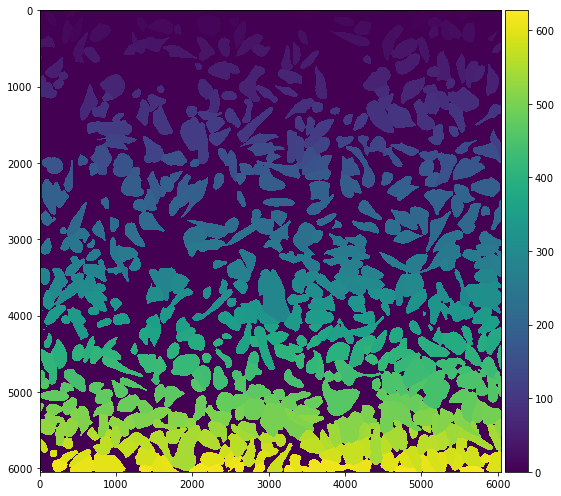

In [48]:
imshow(test_mask)

In [50]:
test_mask

dask.array<getitem, shape=(6048, 6048), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>

For some reason I have to compute the image to perform this operation

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


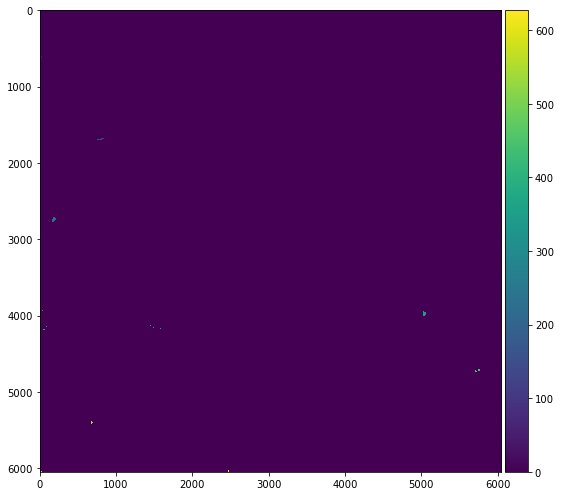

In [54]:
removed = remove_small_objects(test_mask.compute(), min_size = 3000)
imshow(test_mask - removed)

Gauging the size of the strange artefacts

In [82]:
segment = test_mask == 222

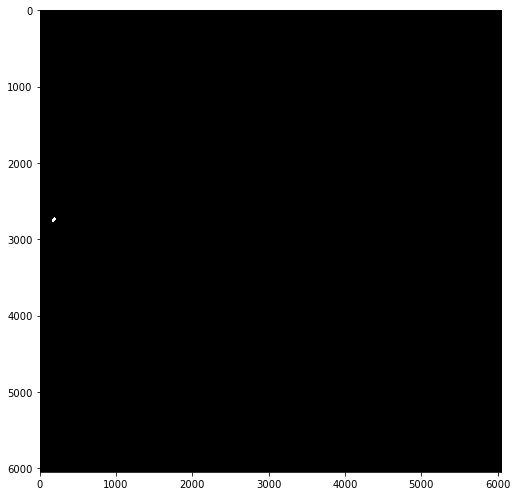

In [83]:
imshow(segment)

In [84]:
da.sum(segment).compute()

1935

The above segment is actually a cell so a filter area of 1935 is too much. Testing segment 440

In [85]:
segment = test_mask == 440

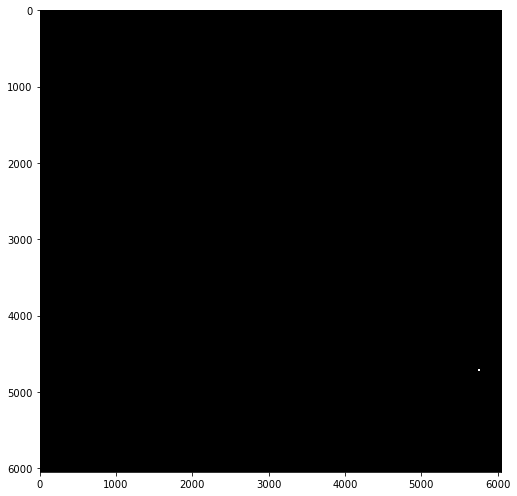

In [86]:
imshow(segment)

In [87]:
da.sum(segment).compute()

806

This segment is not a cell therefore 806 is not too large an area to filter objects. Testing one more segment at ID = 349, what looks to be the upper range of the area of segments.

In [88]:
segment = test_mask == 349

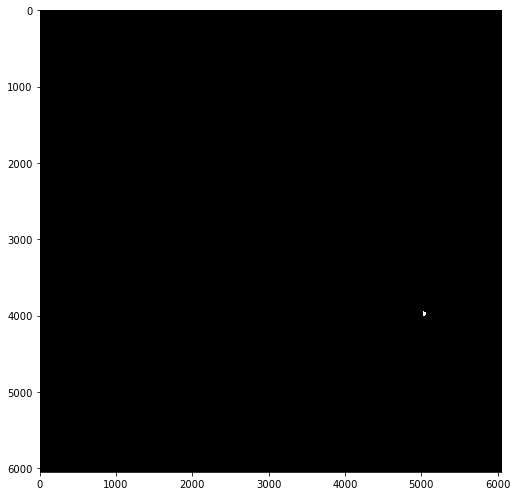

In [89]:
imshow(segment)

In [90]:
da.sum(segment).compute()

2155

Let's try 2000 pixels as the cut off point.

### Applying post-processing on entire mask stack

In [92]:
masks

dask.array<from-zarr, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>

In [103]:
masks_post_process = []
for mask in tqdm(masks):
    mask = remove_small_objects(mask.compute(), min_size = 2000)
    masks_post_process.append(mask)
masks_pp = da.stack(masks_post_process, axis = 0)

  0%|          | 0/75 [00:00<?, ?it/s]

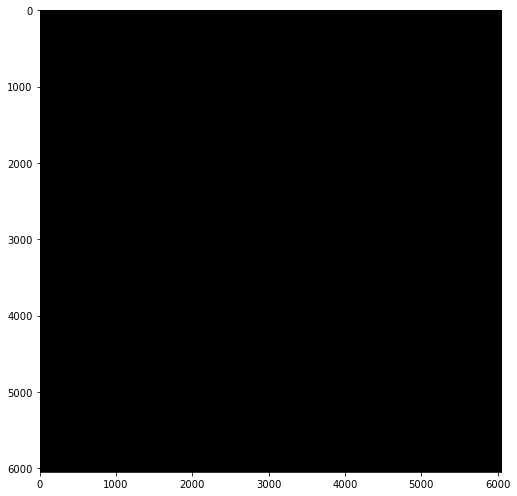

In [107]:
segment = masks_pp[0] == 440
imshow(segment)

In [108]:
da.sum(segment).compute()

0

Looks like the removal of small objects has worked

In [110]:
v = napari.Viewer()
v.add_image(gfp, name="gfp", contrast_limits = [0,3678], blending = 'additive', colormap= 'green')
v.add_image(rfp, name="rfp", contrast_limits = [112,212], blending = 'additive', colormap = 'magenta')
v.add_labels(masks_pp, name = f'masks pp', visible = False,)
v.add_labels(masks, name = f'masks', visible = False,)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'masks' at 0x7f03c8b6d0d0>

Rechunk and save out post-processed masks

In [116]:
masks_pp.rechunk(gfp.chunks)

dask.array<rechunk-merge, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>

In [115]:
masks_pp = masks_pp.rechunk(gfp.chunks)

In [117]:
masks_pp.to_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch99.zarr', overwrite = True)